# Training the EEG (4 convolution and 3 fully connected layers) with early stopping and training, validation and test data split.

## Initialization

In [3]:
# Libraries
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.stats import pearsonr
from scipy.stats import mstats
from scipy.stats import rankdata
from sklearn.metrics import mutual_info_score

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

### Data Loading

In [4]:
# Load the preprocessed EEG data
file_dir = 'Data'
x_path = os.path.join(file_dir, 'x.npy')
y_path = os.path.join(file_dir, 'y.npy')
X = np.load(x_path)
y = np.load(y_path)

# Split the data into training, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Create custom datasets and data loaders
class EEGDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = EEGDataset(X_train, y_train)
val_dataset = EEGDataset(X_val, y_val)
test_dataset = EEGDataset(X_test, y_test)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Nueral Network Model

In [5]:
# Define the EEGNet model
class EEGNet(nn.Module):
    def __init__(self):
        super(EEGNet, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=10, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv5 = nn.Conv1d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(256 * 80, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = nn.functional.relu(self.conv1(x))
        x = self.pool(x)
        x = nn.functional.relu(self.conv2(x))
        x = self.pool(x)
        x = nn.functional.relu(self.conv3(x))
        x = self.pool(x)
        x = nn.functional.relu(self.conv4(x))
        x = self.pool(x)
        x = nn.functional.relu(self.conv5(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x =self.dropout(nn.functional.relu(self.fc1(x)))
        x = self.dropout(nn.functional.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

### Training the Model

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

eeg_net = EEGNet().to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(eeg_net.parameters(), lr=0.001)

num_epochs = 100
best_val_loss = float('inf')
patience = 10
epochs_no_improve = 0
model_save_path = 'eegnet.pth'

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_precisions = []
val_precisions = []
train_recalls = []
val_recalls = []
train_f1s = []
val_f1s = []


for epoch in range(num_epochs):
    eeg_net.train()
    train_loss = 0.0
    train_correct = 0
    all_train_preds = []
    all_train_targets = []
    for batch_idx, (data, target) in enumerate(train_dataloader):
        data, target = data.to(device), target.to(device) 
        optimizer.zero_grad()
        output = eeg_net(data)
        loss = criterion(output.squeeze(), target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        preds = torch.round(torch.sigmoid(output.squeeze()))
        train_correct += (preds == target).sum().item()
        all_train_preds.extend(preds.detach().cpu().numpy())
        all_train_targets.extend(target.detach().cpu().numpy())

    train_loss /= len(train_dataloader)
    train_accuracy = train_correct / len(train_dataloader.dataset)
    train_precision = precision_score(all_train_targets, all_train_preds)
    train_recall = recall_score(all_train_targets, all_train_preds)
    train_f1 = f1_score(all_train_targets, all_train_preds)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    train_precisions.append(train_precision)
    train_recalls.append(train_recall)
    train_f1s.append(train_f1)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, Train F1: {train_f1:.4f}")

    eeg_net.eval()
    val_loss = 0.0
    val_correct = 0
    all_val_preds = []
    all_val_targets = []
    with torch.no_grad():
        for data, target in val_dataloader:
            data, target = data.to(device), target.to(device)
            output = eeg_net(data)
            loss = criterion(output.squeeze(), target)
            val_loss += loss.item()
            preds = torch.round(torch.sigmoid(output.squeeze()))
            val_correct += (preds == target).sum().item()
            all_val_preds.extend(preds.detach().cpu().numpy())
            all_val_targets.extend(target.detach().cpu().numpy())

    val_loss /= len(val_dataloader)
    val_accuracy = val_correct / len(val_dataloader.dataset)
    val_precision = precision_score(all_val_targets, all_val_preds)
    val_recall = recall_score(all_val_targets, all_val_preds)
    val_f1 = f1_score(all_val_targets, all_val_preds)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1s.append(val_f1)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Validation Precision: {val_precision:.4f}, Validation Recall: {val_recall:.4f}, Validation F1: {val_f1:.4f}")

    # Early stopping and model saving
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        best_model = eeg_net.state_dict()
        torch.save(best_model, model_save_path)
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print("Early stopping triggered")
            eeg_net.load_state_dict(best_model)
            torch.save(best_model, model_save_path)
            break

# Also save the final model state after training completes, if early stopping is not triggered
if epochs_no_improve < patience:
    torch.save(best_model, model_save_path)

# Save the final model state after training completes
torch.save(eeg_net.state_dict(), model_save_path)

# Evaluate the model on the test set
eeg_net.eval()
test_loss = 0.0
test_correct = 0
all_test_preds = []
all_test_targets = []
with torch.no_grad():
    for data, target in test_dataloader:
        data, target = data.to(device), target.to(device)
        output = eeg_net(data)
        loss = criterion(output.squeeze(), target)
        test_loss += loss.item()
        preds = torch.round(torch.sigmoid(output.squeeze()))
        test_correct += (preds == target).sum().item()
        all_test_preds.extend(preds.detach().cpu().numpy())
        all_test_targets.extend(target.detach().cpu().numpy())

test_loss /= len(test_dataloader)
test_accuracy = test_correct / len(test_dataloader.dataset)
test_precision = precision_score(all_test_targets, all_test_preds)
test_recall = recall_score(all_test_targets, all_test_preds)
test_f1 = f1_score(all_test_targets, all_test_preds)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}, Test F1: {test_f1:.4f}")


c:\Users\amira\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch [1/100], Train Loss: 0.5753, Train Accuracy: 0.7715, Train Precision: 0.6947, Train Recall: 0.4565, Train F1: 0.5510
Epoch [1/100], Validation Loss: 0.5514, Validation Accuracy: 0.7961, Validation Precision: 0.6116, Validation Recall: 0.6284, Validation F1: 0.6199
Epoch [2/100], Train Loss: 0.4439, Train Accuracy: 0.8388, Train Precision: 0.8717, Train Recall: 0.5573, Train F1: 0.6799
Epoch [2/100], Validation Loss: 0.5162, Validation Accuracy: 0.8434, Validation Precision: 0.9238, Validation Recall: 0.4450, Validation F1: 0.6006
Epoch [3/100], Train Loss: 0.3935, Train Accuracy: 0.8498, Train Precision: 0.9097, Train Recall: 0.5672, Train F1: 0.6987
Epoch [3/100], Validation Loss: 0.3436, Validation Accuracy: 0.8653, Validation Precision: 0.7465, Validation Recall: 0.7431, Validation F1: 0.7448
Epoch [4/100], Train Loss: 0.3491, Train Accuracy: 0.8710, Train Precision: 0.9105, Train Recall: 0.6433, Train F1: 0.7539
Epoch [4/100], Validation Loss: 0.4368, Validation Accuracy: 0.8

### acc, f1, ... Plots

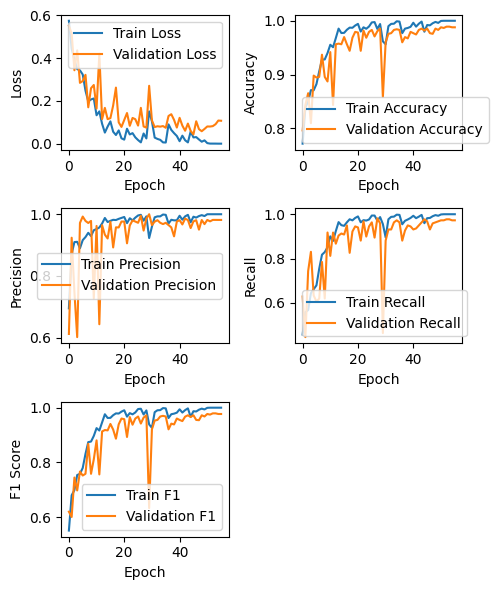

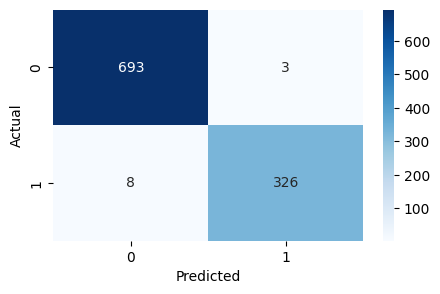

In [5]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 2, figsize=(5, 6))

# Plot the training and validation loss
axs[0, 0].plot(train_losses, label='Train Loss')
axs[0, 0].plot(val_losses, label='Validation Loss')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].legend()

# Plot the training and validation accuracy
axs[0, 1].plot(train_accuracies, label='Train Accuracy')
axs[0, 1].plot(val_accuracies, label='Validation Accuracy')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Accuracy')
axs[0, 1].legend()

# Plot the training and validation precision
axs[1, 0].plot(train_precisions, label='Train Precision')
axs[1, 0].plot(val_precisions, label='Validation Precision')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Precision')
axs[1, 0].legend()

# Plot the training and validation recall
axs[1, 1].plot(train_recalls, label='Train Recall')
axs[1, 1].plot(val_recalls, label='Validation Recall')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Recall')
axs[1, 1].legend()

# Plot the training and validation F1 score
axs[2, 0].plot(train_f1s, label='Train F1')
axs[2, 0].plot(val_f1s, label='Validation F1')
axs[2, 0].set_xlabel('Epoch')
axs[2, 0].set_ylabel('F1 Score')
axs[2, 0].legend()

# Hide the empty subplot (axs[2, 1])
fig.delaxes(axs[2, 1])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()



# confusion matrix for test set
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_test_targets, all_test_preds)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



## Loading the EEGNET

In [8]:
# Load the model
model_load_path = 'eegnet.pth'
eeg_net = EEGNet()
eeg_net.load_state_dict(torch.load(model_load_path))
eeg_net.eval()


RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [7]:
conv1_output = None
conv2_output = None
conv3_output = None
conv4_output = None
conv5_output = None
fc1_output = None

def hook_fn_conv1(module, input, output):
    global conv1_output
    conv1_output = output

def hook_fn_conv2(module, input, output):
    global conv2_output
    conv2_output = output

def hook_fn_conv3(module, input, output):
    global conv3_output
    conv3_output = output

def hook_fn_conv4(module, input, output):
    global conv4_output
    conv4_output = output

def hook_fn_conv5(module, input, output):
    global conv5_output
    conv5_output = output

def hook_fn_fc1(module, input, output):
    global fc1_output
    fc1_output = output

# Load the model
model_load_path = 'eegnet.pth'
eeg_net = EEGNet().to(device)
eeg_net.load_state_dict(torch.load(model_load_path))
eeg_net.eval()

# Register hooks to the first and second convolutional layers
hook_handle_conv1 = eeg_net.conv1.register_forward_hook(hook_fn_conv1)
hook_handle_conv2 = eeg_net.conv2.register_forward_hook(hook_fn_conv2)
hook_handle_conv3 = eeg_net.conv3.register_forward_hook(hook_fn_conv3)
hook_handle_conv4 = eeg_net.conv4.register_forward_hook(hook_fn_conv4)
hook_handle_conv5 = eeg_net.conv5.register_forward_hook(hook_fn_conv5)
hook_handle_fc1 = eeg_net.fc1.register_forward_hook(hook_fn_fc1)


# Forward pass through the model to get the conv1 and conv2 outputs
with torch.no_grad():
    sample_input = torch.tensor(X_test, dtype=torch.float32).to(device)
    _ = eeg_net(sample_input)
    print("Output shape of the first convolutional layer:", conv1_output.shape)
    print("Output shape of the second convolutional layer:", conv2_output.shape)
    print("Output shape of the third convolutional layer:", conv3_output.shape)
    print("Output shape of the fourth convolutional layer:", conv4_output.shape)
    print("Output shape of the fifth convolutional layer:", conv5_output.shape)
    print("Output shape of the first fully connected layer:", fc1_output.shape)

# print("sample_input",sample_input.shape)
# eeg_net.conv1(sample_input.permute(0, 2, 1)  # Change shape from [1, 2560, 10] to [1, 10, 2560]
# ).shape

# flatten the input signal

input_signal = sample_input.permute(0, 2, 1)
print("input_signal",input_signal.shape)

# Flatten to [batch_size, num_channels * sequence_length]
flattened_input = input_signal.reshape(input_signal.size(0), -1)
flattened_input_np = flattened_input.detach().cpu().numpy()
print("flattened_input",flattened_input_np.shape)



NameError: name 'device' is not defined

### Convolutional Layer output

In [8]:
# Process conv1 output
conv1_intermediate_output = conv1_output.view(conv1_output.size(0), -1)
print("conv1_intermediate_output", conv1_intermediate_output.shape)

# Process conv2 output
conv2_intermediate_output = conv2_output.view(conv2_output.size(0), -1)
print("conv2_intermediate_output", conv2_intermediate_output.shape)

# Process conv3 output
conv3_intermediate_output = conv3_output.view(conv3_output.size(0), -1)
print("conv3_intermediate_output", conv3_intermediate_output.shape)

# Process conv4 output
conv4_intermediate_output = conv4_output.view(conv4_output.size(0), -1)
print("conv4_intermediate_output", conv4_intermediate_output.shape)

# Process conv5 output
conv5_intermediate_output = conv5_output.view(conv5_output.size(0), -1)
print("conv5_intermediate_output", conv5_intermediate_output.shape)

# Process fc1 output
fc1_intermediate_output = fc1_output
print("fc1_intermediate_output", fc1_intermediate_output.shape)


# interpolate the conv1 output
interpolated_intermediate_output_conv1 = nn.functional.interpolate(conv1_intermediate_output.unsqueeze(1), size=flattened_input.shape[1], mode='linear', align_corners=False)
interpolated_intermediate_output_conv1 = interpolated_intermediate_output_conv1.squeeze()
interpolated_intermediate_output_conv1_np = interpolated_intermediate_output_conv1.detach().cpu().numpy()
print("interpolated_intermediate_output_conv1", interpolated_intermediate_output_conv1_np.shape)

# interpolate the conv2 output
interpolated_intermediate_output_conv2 = nn.functional.interpolate(conv2_intermediate_output.unsqueeze(1), size=flattened_input.shape[1], mode='linear', align_corners=False)
interpolated_intermediate_output_conv2 = interpolated_intermediate_output_conv2.squeeze()
interpolated_intermediate_output_conv2_np = interpolated_intermediate_output_conv2.detach().cpu().numpy()
print("interpolated_intermediate_output_conv2", interpolated_intermediate_output_conv2_np.shape)

# interpolate the conv3 output
interpolated_intermediate_output_conv3 = nn.functional.interpolate(conv3_intermediate_output.unsqueeze(1), size=flattened_input.shape[1], mode='linear', align_corners=False)
interpolated_intermediate_output_conv3 = interpolated_intermediate_output_conv3.squeeze()
interpolated_intermediate_output_conv3_np = interpolated_intermediate_output_conv3.detach().cpu().numpy()
print("interpolated_intermediate_output_conv3", interpolated_intermediate_output_conv3_np.shape)

# interpolate the conv4 output
interpolated_intermediate_output_conv4 = nn.functional.interpolate(conv4_intermediate_output.unsqueeze(1), size=flattened_input.shape[1], mode='linear', align_corners=False)
interpolated_intermediate_output_conv4 = interpolated_intermediate_output_conv4.squeeze()
interpolated_intermediate_output_conv4_np = interpolated_intermediate_output_conv4.detach().cpu().numpy()
print("interpolated_intermediate_output_conv4", interpolated_intermediate_output_conv4_np.shape)

# interpolate the conv5 output
interpolated_intermediate_output_conv5 = nn.functional.interpolate(conv5_intermediate_output.unsqueeze(1), size=flattened_input.shape[1], mode='linear', align_corners=False)
interpolated_intermediate_output_conv5 = interpolated_intermediate_output_conv5.squeeze()
interpolated_intermediate_output_conv5_np = interpolated_intermediate_output_conv5.detach().cpu().numpy()
print("interpolated_intermediate_output_conv5", interpolated_intermediate_output_conv5_np.shape)

# interpolate the fc1 output
interpolated_intermediate_output_fc1 = nn.functional.interpolate(fc1_intermediate_output.unsqueeze(1), size=flattened_input.shape[1], mode='linear', align_corners=False)
interpolated_intermediate_output_fc1 = interpolated_intermediate_output_fc1.squeeze()
interpolated_intermediate_output_fc1_np = interpolated_intermediate_output_fc1.detach().cpu().numpy()
print("interpolated_intermediate_output_fc1", interpolated_intermediate_output_fc1_np.shape)




conv1_intermediate_output torch.Size([1030, 81920])
conv2_intermediate_output torch.Size([1030, 81920])
conv3_intermediate_output torch.Size([1030, 81920])
conv4_intermediate_output torch.Size([1030, 81920])
conv5_intermediate_output torch.Size([1030, 40960])
fc1_intermediate_output torch.Size([1030, 128])
interpolated_intermediate_output_conv1 (1030, 25600)
interpolated_intermediate_output_conv2 (1030, 25600)
interpolated_intermediate_output_conv3 (1030, 25600)
interpolated_intermediate_output_conv4 (1030, 25600)
interpolated_intermediate_output_conv5 (1030, 25600)
interpolated_intermediate_output_fc1 (1030, 25600)


In [9]:
intermediate_output = conv1_output.view(conv1_output.size(0), -1)
print("intermediate_output",intermediate_output.shape)
interpolated_intermediate_output = nn.functional.interpolate(intermediate_output.unsqueeze(1), size=flattened_input.shape[1], mode='linear', align_corners=False)
interpolated_intermediate_output = interpolated_intermediate_output.squeeze()
interpolated_intermediate_output_np = interpolated_intermediate_output.detach().cpu().numpy()
print("interpolated_intermediate_output",interpolated_intermediate_output_np.shape)

intermediate_output torch.Size([1030, 81920])
interpolated_intermediate_output (1030, 25600)


### Calculating the metrics

In [10]:
def vectorized_pearsonr(x, y):
    x_mean = x.mean(axis=1, keepdims=True)
    y_mean = y.mean(axis=1, keepdims=True)
    x_zero_mean = x - x_mean
    y_zero_mean = y - y_mean
    cov = (x_zero_mean * y_zero_mean).mean(axis=1)
    std_x = np.sqrt((x_zero_mean ** 2).mean(axis=1))
    std_y = np.sqrt((y_zero_mean ** 2).mean(axis=1))
    return cov / (std_x * std_y)
    
def compute_pearson(row_pair):
    return mstats.pearsonr(row_pair[0], row_pair[1])[0]

def compute_metrics(interpolated_intermediate_output, flattened_input, interpolated_intermediate_output_np, flattened_input_np):
    #cosine similarity between the interpolated intermediate output and the flattened input
    cosine_similarities = nn.functional.cosine_similarity(interpolated_intermediate_output.squeeze(), flattened_input, dim=1) 
    cosine_similarities = cosine_similarities.detach().cpu().numpy()
    # print("cosine_similarities",cosine_similarities.shape)

    # Pearson correlation between the interpolated intermediate output and the flattened input
    stacked_arrays = np.dstack((flattened_input_np, interpolated_intermediate_output_np)) # Stack the arrays and apply the function along the rows
    pearson_corrs_mstats = np.apply_along_axis(lambda row: compute_pearson(row.T), 1, stacked_arrays)
    # print(f"Pearson correlations: {pearson_corrs_mstats.shape}")


    # Spearman correlation
    ranked_x = np.apply_along_axis(rankdata, 1, flattened_input_np) # Ranking the data
    ranked_y = np.apply_along_axis(rankdata, 1, interpolated_intermediate_output_np) # Ranking the data 
    spearman_corrs = vectorized_pearsonr(ranked_x, ranked_y)
    # print(f"Spearman correlations: {spearman_corrs.shape}")

    # Mutual information
    mutual_info = [mutual_info_score(flattened_input_np[i], interpolated_intermediate_output_np[i]) for i in range(flattened_input_np.shape[0])]
    # print(f"Mutual information: {len(mutual_info)}")

    # Calculate reconstruction error between raw signal and intermediate output using mean squared error
    reconstruction_errors = np.mean((flattened_input_np - interpolated_intermediate_output_np) ** 2, axis=1)
    # print(f"Reconstruction errors: {reconstruction_errors.shape}")

    # Ecludian distance between the raw signal and intermediate output
    euclidean_distances = np.linalg.norm(flattened_input_np - interpolated_intermediate_output_np, axis=1)
    # print(f"Euclidean distances: {euclidean_distances.shape}")

    return cosine_similarities, pearson_corrs_mstats, spearman_corrs, mutual_info, reconstruction_errors, euclidean_distances

In [11]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

cosine_similarities_conv1, pearson_corrs_mstats_conv1, spearman_corrs_conv1, mutual_info_conv1, reconstruction_errors_conv1, euclidean_distances_conv1 = compute_metrics(interpolated_intermediate_output_conv1, flattened_input, interpolated_intermediate_output_conv1_np, flattened_input_np)

cosine_similarities_conv2, pearson_corrs_mstats_conv2, spearman_corrs_conv2, mutual_info_conv2, reconstruction_errors_conv2, euclidean_distances_conv2 = compute_metrics(interpolated_intermediate_output_conv2, flattened_input, interpolated_intermediate_output_conv2_np, flattened_input_np)

cosine_similarities_conv3, pearson_corrs_mstats_conv3, spearman_corrs_conv3, mutual_info_conv3, reconstruction_errors_conv3, euclidean_distances_conv3 = compute_metrics(interpolated_intermediate_output_conv3, flattened_input, interpolated_intermediate_output_conv3_np, flattened_input_np)

cosine_similarities_conv4, pearson_corrs_mstats_conv4, spearman_corrs_conv4, mutual_info_conv4, reconstruction_errors_conv4, euclidean_distances_conv4 = compute_metrics(interpolated_intermediate_output_conv4, flattened_input, interpolated_intermediate_output_conv4_np, flattened_input_np)

cosine_similarities_conv5, pearson_corrs_mstats_conv5, spearman_corrs_conv5, mutual_info_conv5, reconstruction_errors_conv5, euclidean_distances_conv5 = compute_metrics(interpolated_intermediate_output_conv5, flattened_input, interpolated_intermediate_output_conv5_np, flattened_input_np)

cosine_similarities_fc1, pearson_corrs_mstats_fc1, spearman_corrs_fc1, mutual_info_fc1, reconstruction_errors_fc1, euclidean_distances_fc1 = compute_metrics(interpolated_intermediate_output_fc1, flattened_input, interpolated_intermediate_output_fc1_np, flattened_input_np)
print("cosine_similarities_fc1 shape",cosine_similarities_fc1.shape)
print("pearson_corrs_mstats_fc1 shape",pearson_corrs_mstats_fc1.shape)
print("spearman_corrs_fc1 shape",spearman_corrs_fc1.shape)
print("mutual_info_fc1 shape",len(mutual_info_fc1))
print("reconstruction_errors_fc1 shape",len(reconstruction_errors_fc1))
print("euclidean_distances_fc1 shape",len(euclidean_distances_fc1))

cosine_similarities_fc1 shape (1030,)
pearson_corrs_mstats_fc1 shape (1030, 2)
spearman_corrs_fc1 shape (1030,)
mutual_info_fc1 shape 1030
reconstruction_errors_fc1 shape 1030
euclidean_distances_fc1 shape 1030


In [12]:
cosine_similarities = (cosine_similarities_conv1, cosine_similarities_conv2, cosine_similarities_conv3, cosine_similarities_conv4, cosine_similarities_conv5, cosine_similarities_fc1)
pearson_corrs_mstats = (pearson_corrs_mstats_conv1[:,0], pearson_corrs_mstats_conv2[:,0], pearson_corrs_mstats_conv3[:,0], pearson_corrs_mstats_conv4[:,0], pearson_corrs_mstats_conv5[:,0], pearson_corrs_mstats_fc1[:,0])
spearman_corrs = (spearman_corrs_conv1, spearman_corrs_conv2, spearman_corrs_conv3, spearman_corrs_conv4, spearman_corrs_conv5, spearman_corrs_fc1)
mutual_info = (mutual_info_conv1, mutual_info_conv2, mutual_info_conv3, mutual_info_conv4, mutual_info_conv5, mutual_info_fc1)
reconstruction_errors = (reconstruction_errors_conv1, reconstruction_errors_conv2, reconstruction_errors_conv3, reconstruction_errors_conv4, reconstruction_errors_conv5, reconstruction_errors_fc1)
euclidean_distances = (euclidean_distances_conv1, euclidean_distances_conv2, euclidean_distances_conv3, euclidean_distances_conv4, euclidean_distances_conv5, euclidean_distances_fc1)

In [13]:
pearson_corrs_mstats_conv1

masked_array(
  data=[[--, --],
        [--, --],
        [--, --],
        [--, --],
        [--, --],
        [--, --],
        [--, --],
        [--, --],
        [--, --],
        [--, --],
        [--, --],
        [--, --],
        [--, --],
        [--, --],
        [--, --],
        [--, --],
        [--, --],
        [--, --],
        [--, --],
        [--, --],
        [--, --],
        [--, --],
        [--, --],
        [--, --],
        [--, --],
        [--, --],
        [--, --],
        [--, --],
        [--, --],
        [--, --],
        [--, --],
        [--, --],
        [--, --],
        [--, --],
        [--, --],
        [--, --],
        [--, --],
        [--, --],
        [--, --],
        [--, --],
        [--, --],
        [--, --],
        [--, --],
        [--, --],
        [--, --],
        [--, --],
        [--, --],
        [--, --],
        [--, --],
        [--, --],
        [--, --],
        [--, --],
        [--, --],
        [--, --],
        [--, -

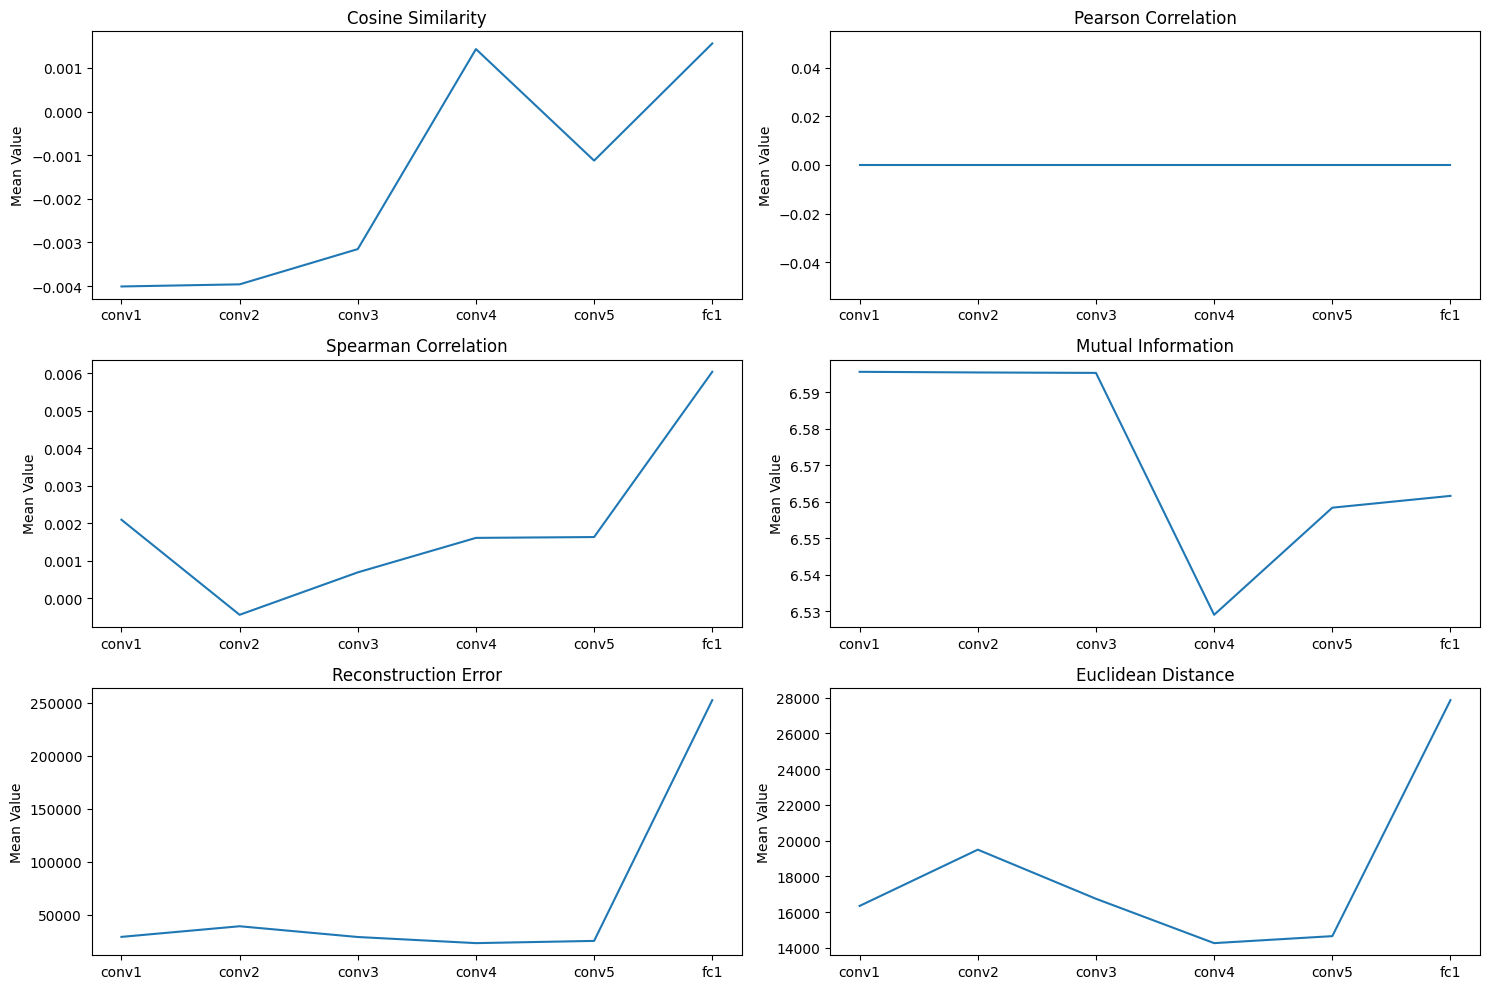

In [14]:
# List of metrics and their labels
metrics = [(cosine_similarities, 'Cosine Similarity'), (pearson_corrs_mstats, 'Pearson Correlation'), 
           (spearman_corrs, 'Spearman Correlation'), (mutual_info, 'Mutual Information'), 
           (reconstruction_errors, 'Reconstruction Error'), (euclidean_distances, 'Euclidean Distance')]
scenarios = ['conv1', 'conv2', 'conv3', 'conv4', 'conv5', 'fc1']

# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each metric
for i, (data, label) in enumerate(metrics):
    data = np.array(data)
    # mean of each scenario
    mean_data = np.mean(data, axis=1)

    axes[i].plot(scenarios, mean_data)
    axes[i].set_title(label)
    axes[i].set_ylabel('Mean Value')

# Adjust layout
plt.tight_layout()
plt.show()

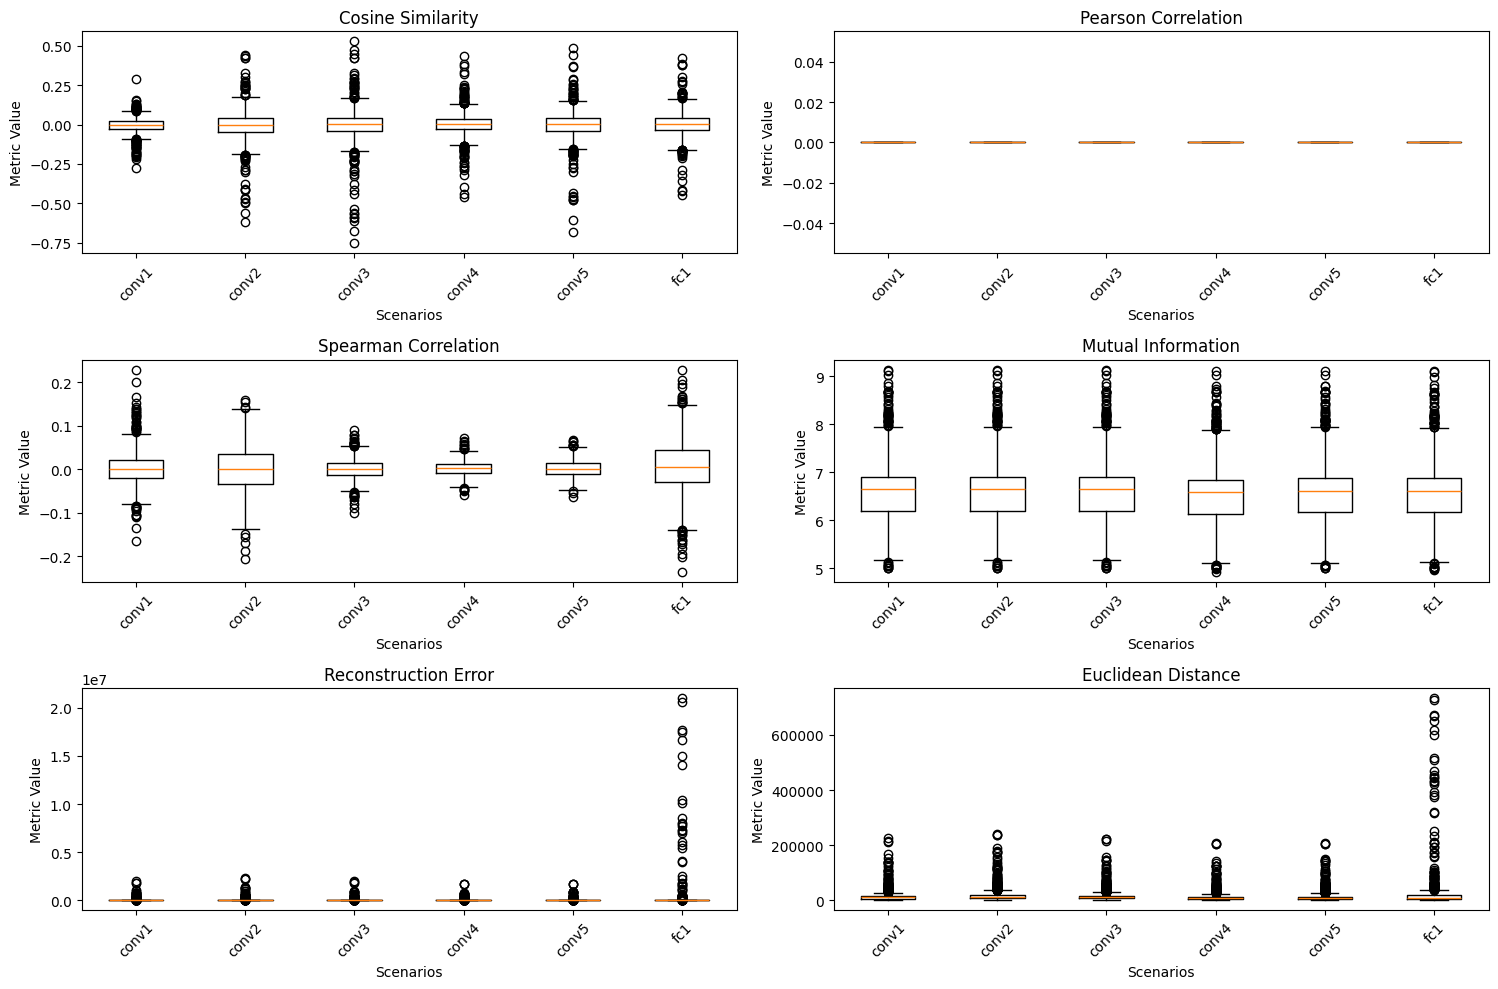

In [15]:

# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each metric
for i, (data, label) in enumerate(metrics):
    axes[i].boxplot(data)
    axes[i].set_title(label)
    axes[i].set_xlabel('Scenarios')
    axes[i].set_ylabel('Metric Value')
    axes[i].set_xticklabels(scenarios, rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

TypeError: MaskedConstant.__new__() takes 1 positional argument but 2 were given

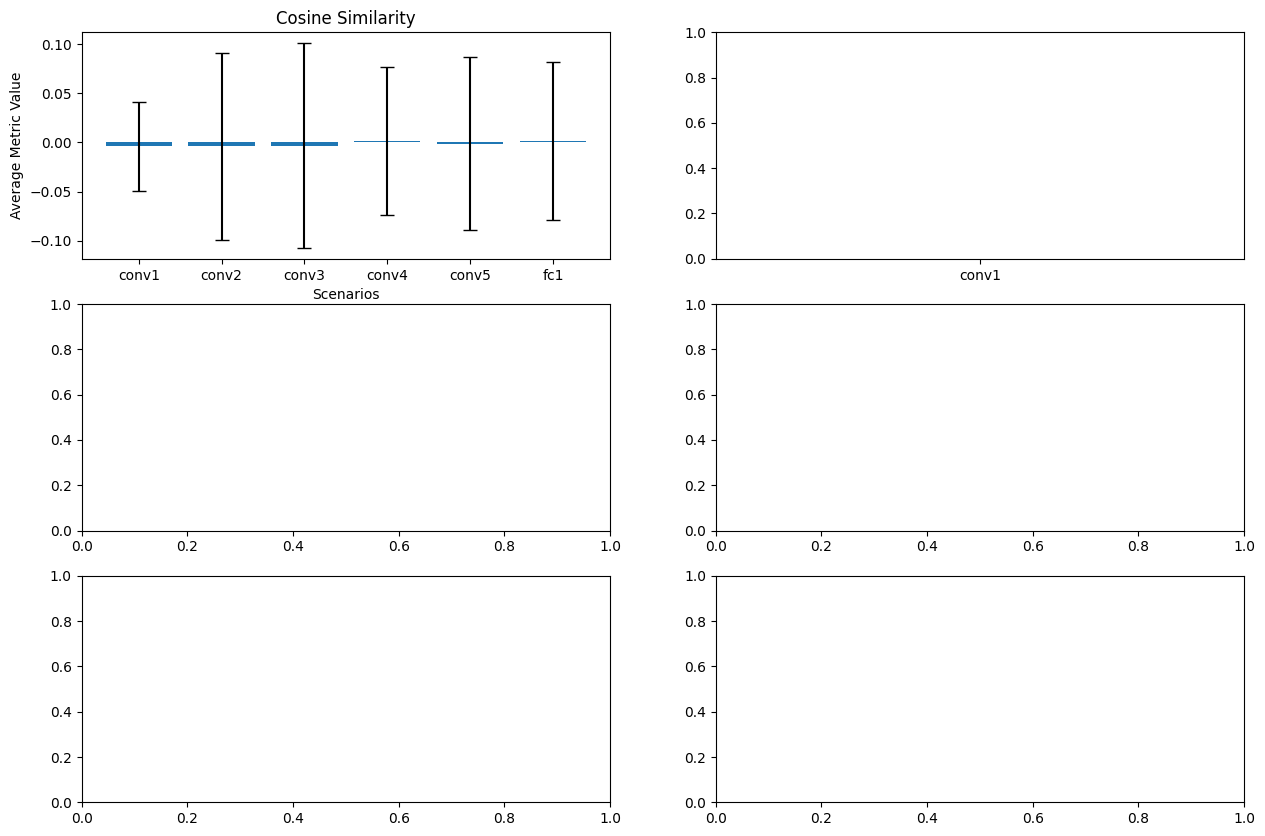

In [16]:
# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot average of each metric
for i, (data, label) in enumerate(metrics):
    axes[i].bar(scenarios, [np.mean(arr) for arr in data], yerr=[np.std(arr) for arr in data], capsize=5)
    axes[i].set_title(label)
    axes[i].set_xlabel('Scenarios')
    axes[i].set_ylabel('Average Metric Value')

# Adjust layout
plt.tight_layout()
plt.show()